In [ ]:
#block 1
# Install PyTorch if needed (usually already installed in Colab)

!pip install --quiet torch torchvision matplotlib

# 📚 Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ✅ Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [ ]:
#block 2
# ─── PINN architecture ───────────────────────────────────────────────────────
class PINN(nn.Module):
    def __init__(self, width=100, depth=5):
        super().__init__()
        layers = []
        in_dim = 2
        for _ in range(depth):
            layers += [nn.Linear(in_dim, width), nn.Tanh()]
            in_dim = width
        layers += [nn.Linear(width,1)]
        self.net = nn.Sequential(*layers)

    def forward(self, tx):
        return self.net(tx)

model = PINN(width=100, depth=5).to(device)



In [ ]:
#block 3
# ─── Total loss = weighted IC + BC + PDE residual ────────────────────────────
def total_loss(model, N_ic, N_bc, N_res, v=2.0, D=0.1):
    # IC
    t_ic, x_ic, q_ic = generate_initial_points(N_ic)
    loss_ic = torch.mean((model(torch.cat([t_ic,x_ic],1)) - q_ic)**2)

    # BC
    loss_bc = boundary_loss_dirichlet(model, N_bc)    # or boundary_loss_periodic

    # Residual
    t_res, x_res = sample_collocation(N_res)
    loss_res = pde_residual_loss(model, t_res, x_res, v, D)

    # weights
    return 10*loss_ic + 10*loss_bc + 1*loss_res



In [ ]:
#block 4
# 🧮 Define the velocity (constant)
v = 1.0  # You can set it to 1.0 for now

# ⚡ Define the PDE loss function
def pde_residual_loss(model, t, x):
    # Make sure t and x require gradients
    t.requires_grad_(True)
    x.requires_grad_(True)

    # Stack t and x together to input to the network
    tx = torch.cat([t, x], dim=1)
    q = model(tx)

    # Compute partial derivatives using autograd
    dq_dt = torch.autograd.grad(outputs=q, inputs=t,
                                grad_outputs=torch.ones_like(q),
                                create_graph=True)[0]

    dq_dx = torch.autograd.grad(outputs=q, inputs=x,
                                grad_outputs=torch.ones_like(q),
                                create_graph=True)[0]

    # Compute the PDE residual
    residual = dq_dt + v * dq_dx

    # Loss is the mean squared residual
    loss = torch.mean(residual**2)
    return loss


In [ ]:
#block 5
# ─── Stratified collocation sampler ───────────────────────────────────────────
from torch.distributions import Beta

def sample_collocation(N):
    α = 0.5  # concentrate near x=0,1
    t = torch.rand(N,1,device=device)
    x = Beta(α,α).sample((N,1)).to(device)
    return t, x



In [ ]:
#block 6
# ─── Dirichlet BC loss: enforce q(t,0)=0 and q(t,1)=0 ───────────────────────────
def boundary_loss_dirichlet(model, N_bc=200):
    t_bc = torch.rand(N_bc,1,device=device)
    tx_left  = torch.cat([t_bc, torch.zeros_like(t_bc)], dim=1)
    tx_right = torch.cat([t_bc, torch.ones_like(t_bc)],  dim=1)
    return torch.mean(model(tx_left)**2) + torch.mean(model(tx_right)**2)



In [ ]:
#block 7
# ─── Residual for q_t + v*q_x - D*q_xx ───────────────────────────────────────────
def pde_residual_loss(model, t, x, v=2.0, D=0.1):
    tx = torch.cat([t, x], dim=1).requires_grad_(True)    # shape (N,2)
    q = model(tx)                                        # (N,1)

    # ∂q/∂t and ∂q/∂x
    grads = torch.autograd.grad(q, tx,
                                grad_outputs=torch.ones_like(q),
                                retain_graph=True, create_graph=True)[0]  # (N,2)
    q_t = grads[:, 0:1]
    q_x = grads[:, 1:2]

    # ∂²q/∂x²
    q_xx = torch.autograd.grad(q_x, tx,
                               grad_outputs=torch.ones_like(q_x),
                               retain_graph=True, create_graph=True)[0][:, 1:2]

    residual = q_t + v*q_x - D*q_xx
    return torch.mean(residual**2)


In [ ]:
# block 8 — two-stage training with pre-sampling and inline losses

# 1) Pre-sample all your data once:
N_ic, N_bc, N_res = 200, 200, 5000
t_ic, x_ic, q_ic     = generate_initial_points(N_ic)
# Use whichever BC function you defined:
loss_bc_fn = boundary_loss_dirichlet  # or boundary_loss_periodic
t_bc_for_loss      = N_bc  # we'll pass N_bc to that fn
t_res, x_res       = sample_collocation(N_res)

# 2) Adam stage
opt_adam = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(5000):
    opt_adam.zero_grad()

    # Initial-condition loss
    pred_ic = model(torch.cat([t_ic, x_ic], dim=1))
    loss_ic = torch.mean((pred_ic - q_ic)**2)

    # Boundary-condition loss
    loss_bc = loss_bc_fn(model, N_bc)

    # PDE residual loss
    loss_res = pde_residual_loss(model, t_res, x_res, v=2.0, D=0.1)

    # Total (with weights)
    loss = 10*loss_ic + 10*loss_bc + 1*loss_res
    loss.backward()
    opt_adam.step()

    if epoch % 100 == 0:
        print(f"[Adam] epoch {epoch:4d}  loss={loss.item():.3e}")

print("✅ Adam stage completed")

# 3) LBFGS stage
opt_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)
closure_counter = {'n': 0}

def closure():
    closure_counter['n'] += 1
    opt_lbfgs.zero_grad()

    # recompute same IC, BC, residual losses as above
    pred_ic = model(torch.cat([t_ic, x_ic], dim=1))
    loss_ic = torch.mean((pred_ic - q_ic)**2)
    loss_bc = loss_bc_fn(model, N_bc)
    loss_res = pde_residual_loss(model, t_res, x_res, v=2.0, D=0.1)
    loss    = 10*loss_ic + 10*loss_bc + loss_res

    loss.backward()
    if closure_counter['n'] % 10 == 0:
        print(f"[LBFGS] closure #{closure_counter['n']}  loss={loss.item():.3e}")
    return loss

opt_lbfgs.step(closure)
print(f"✅ LBFGS done (total closures: {closure_counter['n']})")


[Adam] epoch    0  loss=1.220e-02
[Adam] epoch  100  loss=7.047e-01
[Adam] epoch  200  loss=6.569e-01
[Adam] epoch  300  loss=6.362e-01
[Adam] epoch  400  loss=5.692e-01
[Adam] epoch  500  loss=1.133e-01
[Adam] epoch  600  loss=1.109e-02
[Adam] epoch  700  loss=7.045e-03
[Adam] epoch  800  loss=4.452e-03
[Adam] epoch  900  loss=3.451e-03
[Adam] epoch 1000  loss=3.602e-03
[Adam] epoch 1100  loss=2.445e-03
[Adam] epoch 1200  loss=2.621e-03
[Adam] epoch 1300  loss=2.311e-03
[Adam] epoch 1400  loss=2.468e-03
[Adam] epoch 1500  loss=2.061e-03
[Adam] epoch 1600  loss=1.720e-03
[Adam] epoch 1700  loss=2.258e-03
[Adam] epoch 1800  loss=1.337e-02
[Adam] epoch 1900  loss=1.567e-03
[Adam] epoch 2000  loss=1.567e-03
[Adam] epoch 2100  loss=1.192e-03
[Adam] epoch 2200  loss=1.331e-03
[Adam] epoch 2300  loss=3.016e-03
[Adam] epoch 2400  loss=1.443e-03
[Adam] epoch 2500  loss=1.807e-03
[Adam] epoch 2600  loss=1.288e-03
[Adam] epoch 2700  loss=1.532e-03
[Adam] epoch 2800  loss=1.488e-03
[Adam] epoch 2

In [ ]:
# block 9 — FD + PINN + Analytic on a single (t,x) grid

import numpy as np

# --- Grids & parameters (reuse your L, T, Nx, Nt, v, D) ---
x = np.linspace(0, L, Nx)        # space: 0→L in Nx points
t = np.linspace(0, T, Nt+1)      # time: 0→T in Nt+1 points

# 1) Improved FD solution (shape = (Nt+1, Nx))
Q_fd  = fd_solver_improved(x, t, v=v, D=D)
q_all = Q_fd.copy()              # backward compatibility

# 2) Consistent meshgrid for (t,x) → both shape (Nt+1, Nx)
Tg, Xg = np.meshgrid(t, x, indexing='ij')

# 3) PINN prediction on that same grid
tx      = torch.tensor(
    np.stack([Tg.ravel(), Xg.ravel()], axis=1),
    dtype=torch.float32,
).to(device)
with torch.no_grad():
    Q_pinn_on_fd = model(tx).cpu().numpy().reshape(Tg.shape)

# 4) Analytic solution on that grid
Q_true = np.exp(-D * (np.pi**2) * Tg) * np.sin(np.pi * (Xg - v * Tg))


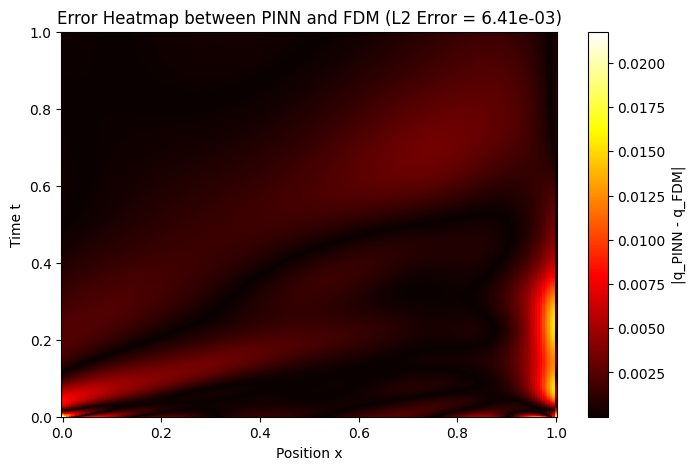

In [ ]:
#block 10
import torch

# 🔁 Create meshgrid for PINN predictions
T_grid, X_grid = np.meshgrid(t, x, indexing='ij')  # shape (Nt, Nx)
tx_points = np.stack([T_grid.ravel(), X_grid.ravel()], axis=1)
tx_tensor = torch.tensor(tx_points, dtype=torch.float32).to(device)

# 📈 Evaluate PINN model on full domain
model.eval()
with torch.no_grad():
    q_pinn = model(tx_tensor).cpu().numpy().reshape(T_grid.shape)

# 📊 Compute absolute error and L2 norm
error_abs = np.abs(q_pinn - q_all)
l2_error = np.sqrt(np.mean((q_pinn - q_all) ** 2)) / np.sqrt(np.mean(q_all ** 2))

# 🔥 Plot heatmap of error
plt.figure(figsize=(8, 5))
plt.pcolormesh(X_grid, T_grid, error_abs, shading='auto', cmap='hot')
plt.colorbar(label='|q_PINN - q_FDM|')
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title(f"Error Heatmap between PINN and FDM (L2 Error = {l2_error:.2e})")
plt.show()


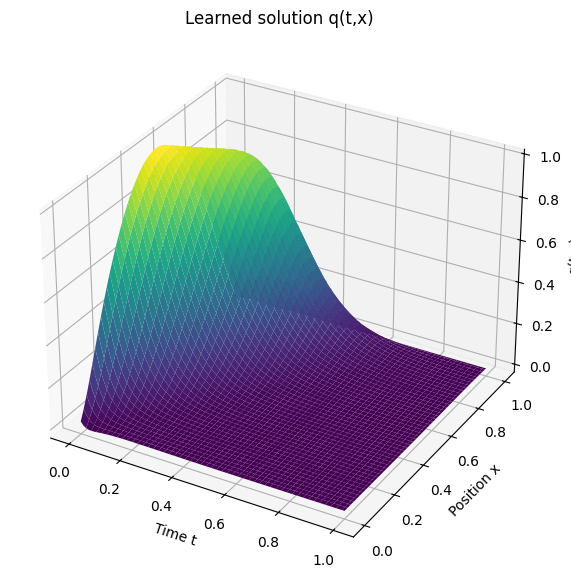

In [ ]:
#block 11
import numpy as np

# Set model to evaluation mode
model.eval()

# Create a meshgrid for t and x
t_plot = torch.linspace(0, 1, 100).to(device)
x_plot = torch.linspace(0, 1, 100).to(device)
T_plot, X_plot = torch.meshgrid(t_plot, x_plot, indexing='ij')

# Flatten the grid and stack (t,x) pairs
tx_plot = torch.cat([T_plot.reshape(-1,1), X_plot.reshape(-1,1)], dim=1)

# Predict q(t,x) using the trained model
with torch.no_grad():
    q_plot = model(tx_plot)
q_plot = q_plot.cpu().numpy().reshape(100, 100)

# Convert T and X to CPU for plotting
T_plot = T_plot.cpu().numpy()
X_plot = X_plot.cpu().numpy()

# 📈 Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T_plot, X_plot, q_plot, cmap='viridis')

ax.set_xlabel('Time t')
ax.set_ylabel('Position x')
ax.set_zlabel('q(t,x)')
ax.set_title('Learned solution q(t,x)')
plt.show()


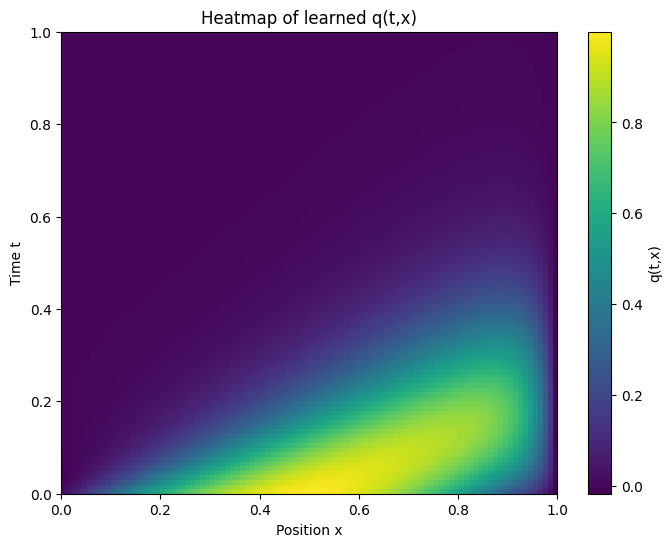

In [ ]:
#block 12
# 🌡️ Heatmap for q(t,x)
import matplotlib.pyplot as plt

# Create fine grid for plotting
t_plot = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
x_plot = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
t_plot_grid, x_plot_grid = torch.meshgrid(t_plot.squeeze(), x_plot.squeeze(), indexing='ij')

# Flatten and predict
tx_plot = torch.cat([t_plot_grid.reshape(-1,1), x_plot_grid.reshape(-1,1)], dim=1)
q_pred = model(tx_plot).detach().cpu().numpy()
q_pred = q_pred.reshape(100, 100)

# Plot
plt.figure(figsize=(8,6))
plt.imshow(q_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='q(t,x)')
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title('Heatmap of learned q(t,x)')
plt.show()


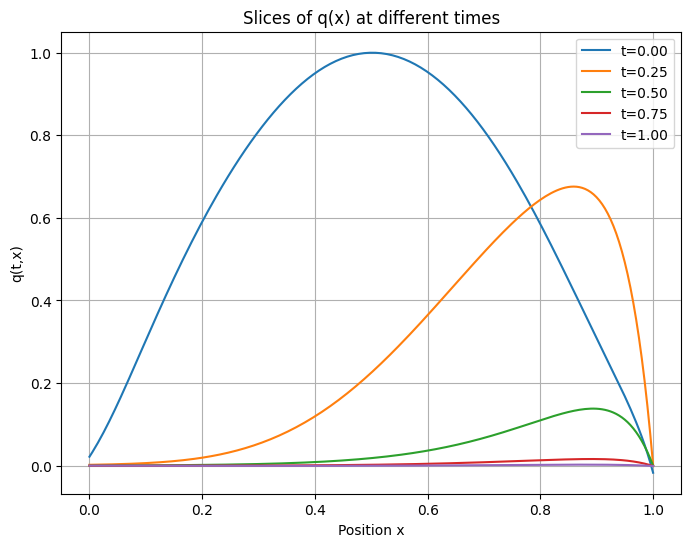

In [ ]:
13
# 📈 Slices at different time steps
times_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0]  # Times you want slices at
x_fine = torch.linspace(0, 1, 200, device=device).unsqueeze(1)

plt.figure(figsize=(8,6))
for t_val in times_to_plot:
    t_tensor = torch.full_like(x_fine, t_val)
    tx_input = torch.cat([t_tensor, x_fine], dim=1)
    q_slice = model(tx_input).detach().cpu().numpy()
    plt.plot(x_fine.cpu().numpy(), q_slice, label=f't={t_val:.2f}')

plt.xlabel('Position x')
plt.ylabel('q(t,x)')
plt.title('Slices of q(x) at different times')
plt.legend()
plt.grid(True)
plt.show()


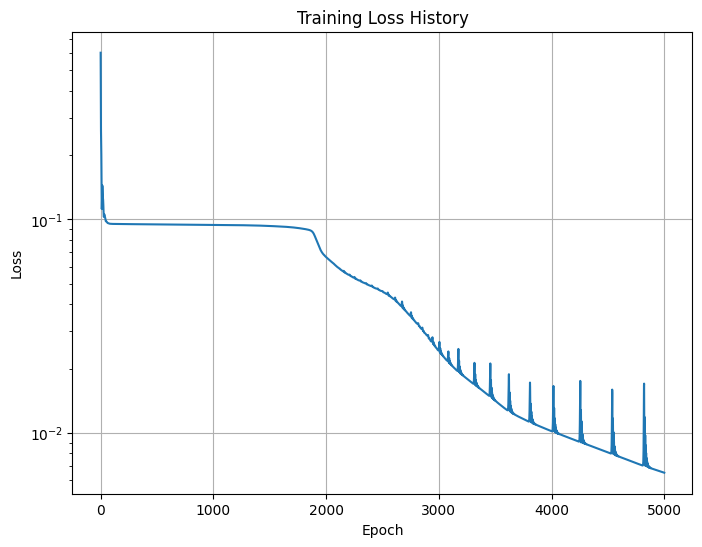

In [ ]:
#block 14
# 📉 Loss Curve
plt.figure(figsize=(8,6))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.yscale('log')  # Optional: makes it easier to see small values
plt.grid(True)
plt.show()


L2 Error between PINN and True Solution: 3.733856e-01


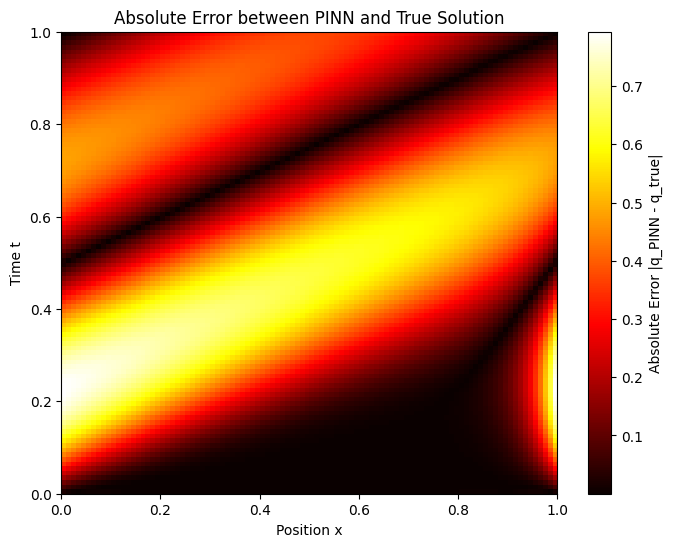

In [ ]:
#block 15
import numpy as np

# Define the true analytical solution function
def true_solution(t, x, v=2.0, D=0.1):
    return np.exp(-D * (np.pi**2) * t) * np.sin(np.pi * (x - v * t))

# Create a fine grid for testing
t_test = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
x_test = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
T_test, X_test = torch.meshgrid(t_test.squeeze(), x_test.squeeze(), indexing='ij')

t_test_flat = T_test.reshape(-1,1)
x_test_flat = X_test.reshape(-1,1)

# Predict with PINN model
model.eval()
tx_test_input = torch.cat([t_test_flat, x_test_flat], dim=1)
q_pred_test = model(tx_test_input).detach().cpu().numpy().flatten()

# Calculate true solution
t_np = t_test_flat.cpu().numpy().flatten()
x_np = x_test_flat.cpu().numpy().flatten()
q_true = true_solution(t_np, x_np)

# Compute L2 Error
error = np.sqrt(np.mean((q_pred_test - q_true)**2))
print(f"L2 Error between PINN and True Solution: {error:.6e}")

# Plot absolute error as heatmap
error_grid = np.abs(q_pred_test - q_true).reshape(100, 100)

plt.figure(figsize=(8,6))
plt.imshow(error_grid, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='Absolute Error |q_PINN - q_true|')
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.title('Absolute Error between PINN and True Solution')
plt.show()


In [ ]:
#block 16  — FD vs PINN error comparison on the same grid

# (1) Grab the FD solution from Block 9:
#    Block 9 defined x (shape Nx), t (shape Nt+1), and q_all (shape (Nt+1,Nx))
#    so we can just reuse those:
Q_fd   = q_all.copy()       # classical FD result
Xg, Tg = X_grid, T_grid     # from your Block 9 meshgrid

# (2) Evaluate PINN on the exact same (Tg,Xg) grid:
tx = torch.tensor(
    np.stack([Tg.ravel(), Xg.ravel()], axis=1),
    dtype=torch.float32,
).to(device)
with torch.no_grad():
    Q_pinn_on_fd = model(tx).cpu().numpy().reshape(Tg.shape)

# (3) Analytic solution on that grid:
Q_true = np.exp(-D * (np.pi**2) * Tg) * np.sin(np.pi * (Xg - v * Tg))

# (4) Compute L2 and Linf errors
def compute_errors(A, B):
    L2   = np.linalg.norm(A - B) / np.sqrt(A.size)
    Linf = np.max(np.abs(A - B))
    return L2, Linf

err_fd,   err_pinn = compute_errors(Q_fd,   Q_true), compute_errors(Q_pinn_on_fd, Q_true)
print(f"FD   : L2={err_fd[0]:.2e}, L∞={err_fd[1]:.2e}")
print(f"PINN : L2={err_pinn[0]:.2e}, L∞={err_pinn[1]:.2e}")


FD   : L2=3.74e-01, L∞=7.91e-01
PINN : L2=3.74e-01, L∞=7.93e-01


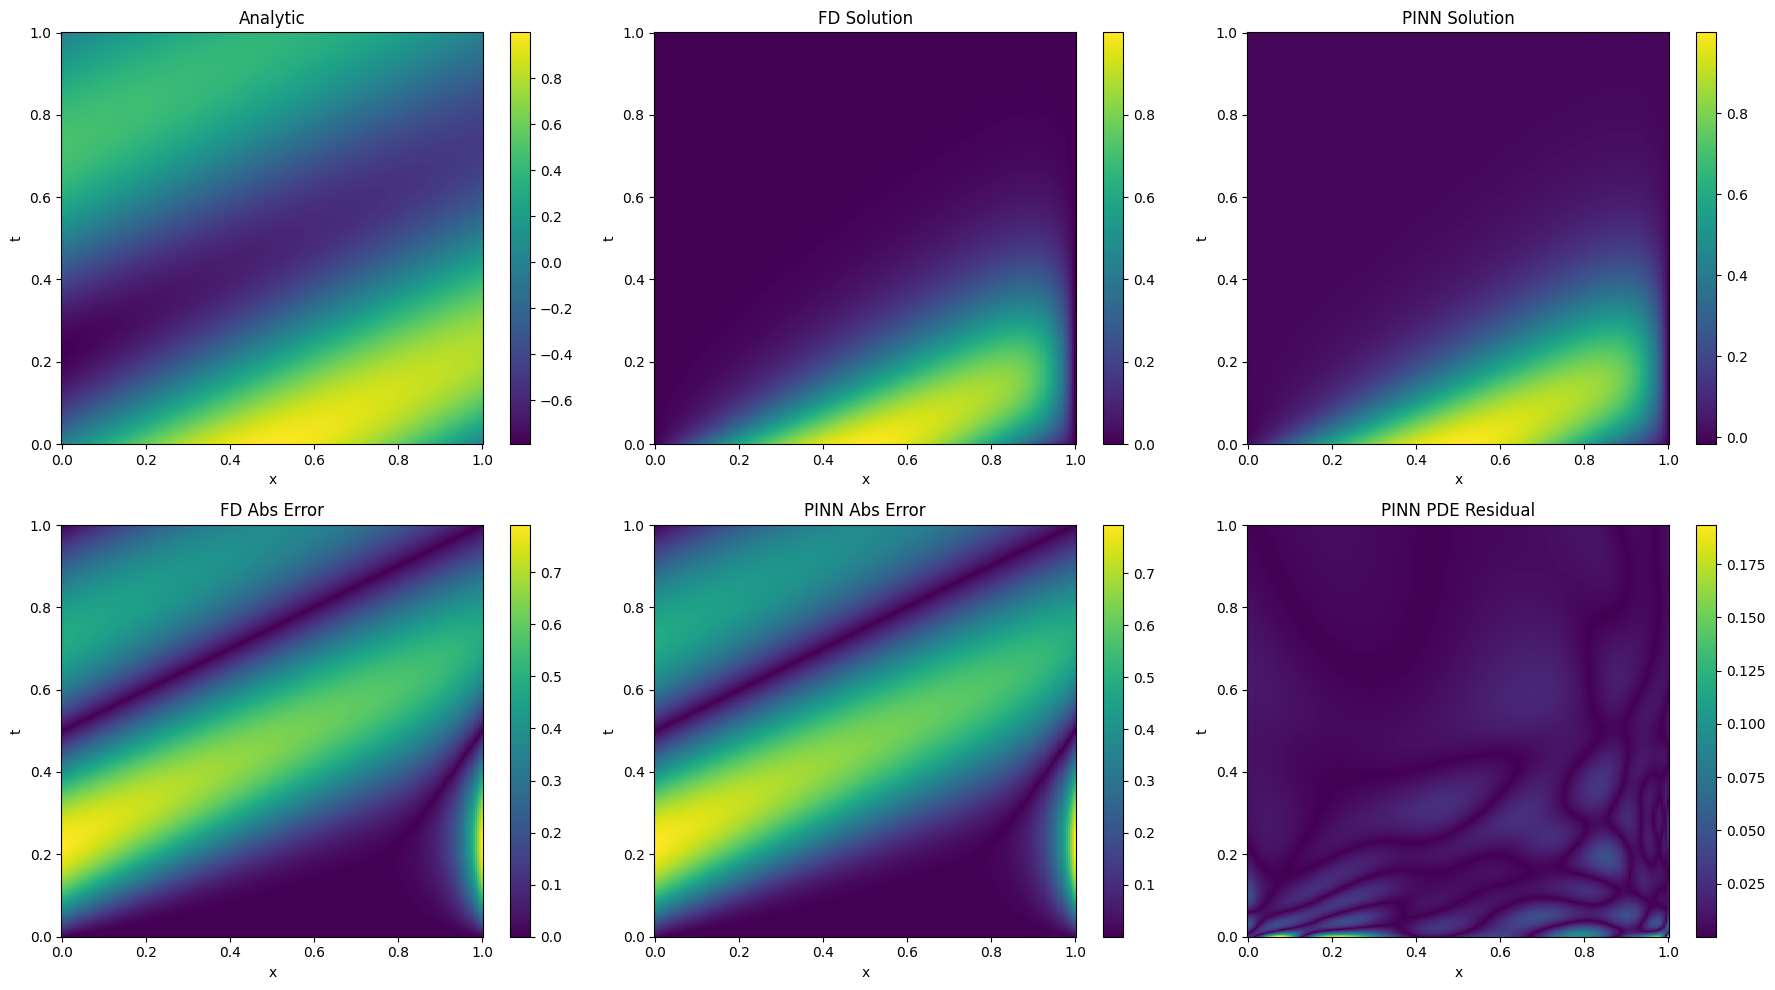

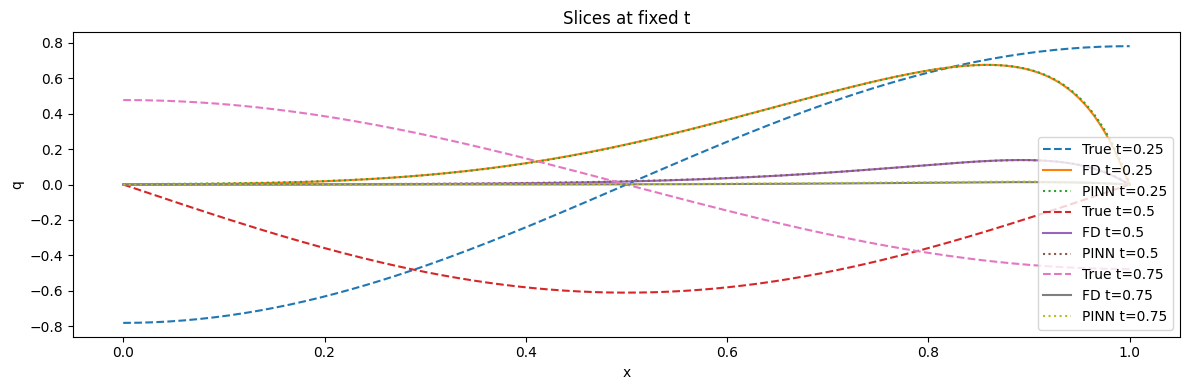

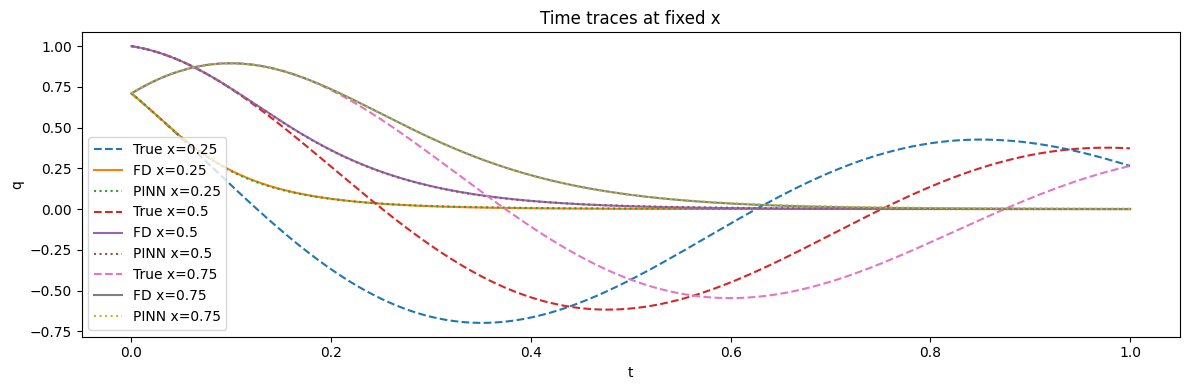

In [ ]:
# block 17 — Fast PINN residual + 2×3 heatmaps + slice plots

import numpy as np
import matplotlib.pyplot as plt
import torch

# 1) Compute FD & PINN errors
err_fd   = np.abs(Q_fd   - Q_true)
err_pinn = np.abs(Q_pinn_on_fd - Q_true)

# 2) Build float32 torch inputs for the full (t,x) grid
T_flat = Tg.ravel().astype(np.float32)
X_flat = Xg.ravel().astype(np.float32)
tx_all = torch.tensor(
    np.stack([T_flat, X_flat], axis=1),
    device=device, requires_grad=True,
)

# 3) PINN prediction and first derivatives
q_pred = model(tx_all)  # shape (N,1), float32
grads  = torch.autograd.grad(
    q_pred, tx_all,
    grad_outputs=torch.ones_like(q_pred),
    create_graph=True,
)[0]                    # shape (N,2)
q_t = grads[:,0]         # ∂q/∂t
q_x = grads[:,1]         # ∂q/∂x

# 4) Vectorized second x-derivative
grads2 = torch.autograd.grad(
    q_x.unsqueeze(1), tx_all,
    grad_outputs=torch.ones_like(q_x).unsqueeze(1),
    create_graph=False,
)[0]                    # shape (N,2)
q_xx = grads2[:,1]      # ∂²q/∂x²

# 5) Detach & reshape back to grid
q_t_np   = q_t.detach().cpu().numpy().reshape(Tg.shape)
q_xx_np  = q_xx.detach().cpu().numpy().reshape(Tg.shape)
res_pinn = np.abs(q_t_np + v*q_x.detach().cpu().numpy().reshape(Tg.shape)
                  - D*q_xx_np)

# 6) Six  heatmaps: analytic, FD, PINN, FD error, PINN error, PINN residual
fig, axs = plt.subplots(2, 3, figsize=(18,10))
maps = [
    (Q_true,       "Analytic"),
    (Q_fd,         "FD Solution"),
    (Q_pinn_on_fd, "PINN Solution"),
    (err_fd,       "FD Abs Error"),
    (err_pinn,     "PINN Abs Error"),
    (res_pinn,     "PINN PDE Residual"),
]
for ax, (data, title) in zip(axs.flatten(), maps):
    im = ax.pcolormesh(Xg, Tg, data, shading='auto')
    ax.set_title(title)
    ax.set_xlabel("x"); ax.set_ylabel("t")
    fig.colorbar(im, ax=ax)
plt.tight_layout()

# 7) Line slices at fixed times
times = [0.25, 0.5, 0.75]
i_t   = [np.argmin(np.abs(t - time)) for time in times]
plt.figure(figsize=(12,4))
for idx, time in zip(i_t, times):
    plt.plot(x, Q_true[idx],    '--', label=f"True t={time}")
    plt.plot(x, Q_fd[idx],       '-', label=f"FD t={time}")
    plt.plot(x, Q_pinn_on_fd[idx],':', label=f"PINN t={time}")
plt.title("Slices at fixed t"); plt.xlabel("x"); plt.ylabel("q"); plt.legend(); plt.tight_layout()

# 8) Time traces at fixed positions
positions = [0.25, 0.5, 0.75]
i_x       = [np.argmin(np.abs(x - pos)) for pos in positions]
plt.figure(figsize=(12,4))
for ix, pos in zip(i_x, positions):
    plt.plot(t, Q_true[:,ix],    '--', label=f"True x={pos}")
    plt.plot(t, Q_fd[:,ix],       '-', label=f"FD x={pos}")
    plt.plot(t, Q_pinn_on_fd[:,ix],':', label=f"PINN x={pos}")
plt.title("Time traces at fixed x"); plt.xlabel("t"); plt.ylabel("q"); plt.legend(); plt.tight_layout()
